# 1. Setup

In [834]:
import pandas as pd
import datetime as dt
import numpy as np

import matplotlib.pylab as plt
import matplotlib.dates as mdates

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
#Show plots inline
%matplotlib inline

#Some date formatters to use for plotting 
weeks = mdates.WeekdayLocator()
years = mdates.YearLocator()
months = mdates.MonthLocator()
weekdays = mdates.DayLocator()
dateFmt = mdates.DateFormatter('%b-%y')

In [835]:
#seaborn is a useful package for handling graphics and 
#producing publication quality images with better colour schemes
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_context("talk")
#sns.set(font_scale=1.5) 
#sns.set_context("poster")

plt.rcParams.update({'font.size': 32})
plt.rcParams.update({'lines.linewidth':3})

In [836]:
from uk_covid19 import Cov19API

In [837]:
#Admin hierarchy of data (can also be regional and local)
areaType = 'nation'
area_filter = ['areaType={}'.format(areaType)]

#Form the API query
query = { "areaType":"areaType" ,"areaName":"areaName" ,"areaCode":"areaCode","specimenDate":"date"
         ,"dailyLabConfirmedCases":"newCasesBySpecimenDate","hospital":"hospitalCases"
         ,"newAdmissions":"newAdmissions","deaths":"newDeaths28DaysByDeathDate"
         ,"newPeopleVaccinatedCompletePublishDate":"newVaccinesGivenByPublishDate"
        }
api_query = Cov19API(filters=area_filter, structure=query)

#return a pandas dataframe. Other formats can be used e.g. JSON etc.
df = api_query.get_dataframe()

#rename columns
df.columns = ['Area type', 'Area name', 'Area code', 'Date', 'Cases','Hospital', 'Admissions', 'Deaths', 'Vaccinated']
#Re-index by date
df.set_index(pd.to_datetime(df['Date'], format='%Y-%m-%d'),inplace=True)
df.sort_index(inplace=True)
#Select just England data but Wales, Scoltand, and Northern Ireland can also be chosen
df_Eng = df[df['Area name']=='England'].copy()

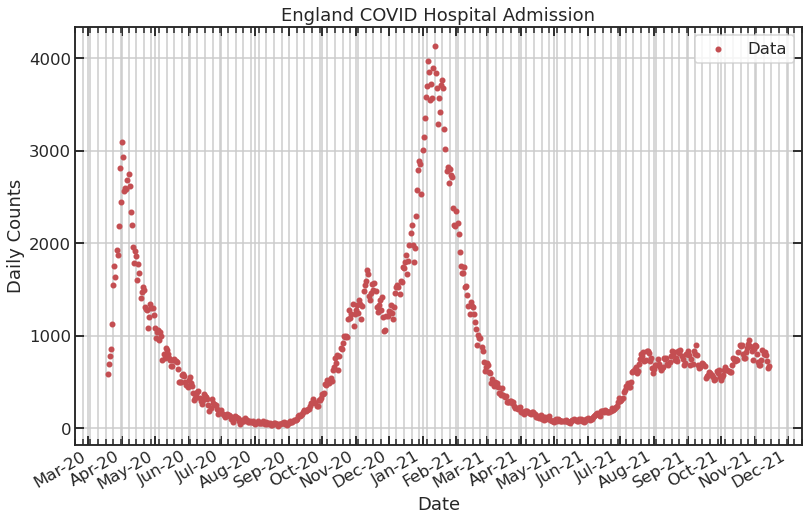

In [838]:
#Plot up some data
fig, ax = plt.subplots(figsize=(12,8),sharex= True, facecolor='white')

ax.scatter(df_Eng.index,df_Eng['Admissions'],label='Data',marker='.',c='C3')
#Make it pretty
ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)

#ax.set_ylim(bottom=0)
ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Counts')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
#ax.set_xlim(left=dt.datetime(2020,12,1))
ax.set_title('England COVID Hospital Admission')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('example.png')

In [839]:
#Import the data from Google.
#This is a large file!
df_google = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')

/home/hl3520/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [840]:
#Select `United Kingdom` from the full data.
df_google = df_google[df_google['country_region']=='United Kingdom']
#Discard sub regions
#Note - we England vs UK
df_google = df_google[df_google['sub_region_1'].isnull()]

In [841]:
#Re-index by data
df_google.set_index(pd.to_datetime(df_google['date']),inplace=True)
df_google.sort_index(inplace=True)


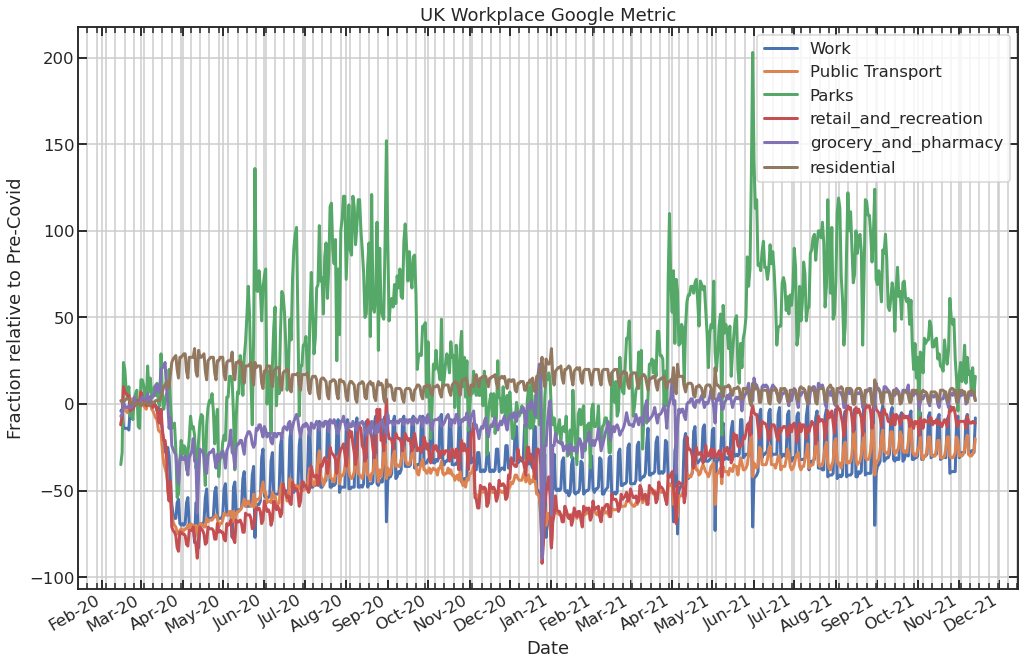

In [842]:
fig, ax = plt.subplots(figsize=(15,10),sharex= True, facecolor='white')

ax.plot(df_google.index,df_google['workplaces_percent_change_from_baseline'],label='Work')
ax.plot(df_google.index,df_google['transit_stations_percent_change_from_baseline'],label='Public Transport')
ax.plot(df_google.index,df_google['parks_percent_change_from_baseline'],label='Parks')
ax.plot(df_google.index,df_google['retail_and_recreation_percent_change_from_baseline'],label='retail_and_recreation')
ax.plot(df_google.index,df_google['grocery_and_pharmacy_percent_change_from_baseline'],label='grocery_and_pharmacy')
ax.plot(df_google.index,df_google['residential_percent_change_from_baseline'],label='residential')

ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)


ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Fraction relative to Pre-Covid')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
#ax.set_xlim(left=dt.datetime(2021,7,1))
ax.set_title('UK Workplace Google Metric')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('mobility.png')

# 2. Answer for the second assignment 

##  Part 1. Clean the data of periodic systematics

The goal of this project is to build a model to show how the number of infections varies with different combination of variables of interest. Therefore, before building a model, I need to choose suitable covariates and a dependent variable first. According to the given requirements, starting with mobility metrics as covariates is a good choice, because the degree of people gathering can affect the rate of the covid spread, and indirectly (time-lagged) influence the number of infected people. Hospital admission is also very appropriate to be chosen as a dependent variable to show the changes in the number of infections, because when someone is admitted to a hospital during the special period, he or she definitely gets tested positive for covid.

By observing the trend of these selected variables over time, I found that they all have periodic systematics, caused by people's life or work routines, etc. In order to reduce potential systematic errors and improve the accuracy of the model, DataFrame.rolling is a great method to clean data, adding a 7-day rolling average window of variables.  

In [843]:
import pandas as pd

#Use DataFrame.rolling() to clean the data for all variables
work_clean_noise = df_google['workplaces_percent_change_from_baseline'].rolling(window=7).mean()
Public_Transport_clean_noise = df_google['transit_stations_percent_change_from_baseline'].rolling(window=7).mean()
Parks_clean_noise = df_google['parks_percent_change_from_baseline'].rolling(window=7).mean()
retail_and_recreation_clean_noise = df_google['retail_and_recreation_percent_change_from_baseline'].rolling(window=7).mean()
grocery_and_pharmacy_clean_noise = df_google['grocery_and_pharmacy_percent_change_from_baseline'].rolling(window=7).mean()
residential_clean_noise = df_google['residential_percent_change_from_baseline'].rolling(window=7).mean()
hospital_admission_clean_noise = df_Eng['Admissions'].rolling(window=7).mean()

One more thing to note is that covid infection has the latent period, so condering time-lagged for mobility metrics is very necessary when constructing a desired dataframe. DataFrame.shift() can be used to shift specified number of periods. As for choosing the value of time shift, I try 10 days first which means the number of hospital admissions per day is related to the values of mobility metrics from ten days ago. If the fitting result is not very good with a shift time of ten days, I would return to this part, change the value of shift time, compare the accuracy of different fits and try to get a better model. In fact, after trying different shift time from 5 days to 20 days, the choice of ten days eventually proved to be the best.

In [844]:
#Create a dataframe including all concerned mobility metrics as covariates 
data={'work':work_clean_noise,
     'Public_Transport':Public_Transport_clean_noise,
     'Parks':Parks_clean_noise,
     'retail_and_recreation': retail_and_recreation_clean_noise,
      'grocery_and_pharmacy': grocery_and_pharmacy_clean_noise,
      'residential': residential_clean_noise
     }

df = pd.DataFrame(data)
# Use df.shift() to do time-lagged for these mobility metrics
# And get a new dataframe
time_lagged = 10
df_new = df.shift(time_lagged)

# Add hospital admission as a dependent variable for this new dataframe
df_new['hospital_admission'] = hospital_admission_clean_noise

#Remove rows in this dataframe that have null value
df_new.dropna(axis=0, how='any', inplace=True)

After removing rows containing null values, a new dataframe including all variables I concerned is available which is much more covenient and straightforward for experimenting using linear regression to create a model in the next part.

In [845]:
display(df_new)

,work,Public_Transport,Parks,retail_and_recreation,grocery_and_pharmacy,residential,hospital_admission
date,,,,,,,
2020-03-25,-1.571429,-8.714286,5.000000,-3.714286,7.142857,1.571429,1048.571429
2020-03-26,-2.857143,-10.571429,8.571429,-4.142857,9.428571,2.000000,1199.000000
2020-03-27,-5.142857,-13.857143,8.857143,-6.000000,11.714286,2.857143,1376.142857
2020-03-28,-8.428571,-17.857143,7.000000,-9.000000,14.142857,4.142857,1532.714286
2020-03-29,-12.142857,-22.000000,6.571429,-11.857143,16.000000,5.428571,1722.285714
...,...,...,...,...,...,...,...
2021-11-09,-30.428571,-26.857143,39.571429,-5.142857,4.428571,6.428571,756.428571
2021-11-10,-30.428571,-27.142857,34.571429,-5.714286,4.857143,6.428571,758.428571
2021-11-11,-29.142857,-27.142857,28.285714,-7.000000,4.571429,6.428571,769.857143


##  Part 2. Experiment using linear regression to create a model 

After getting all information I need in the DataFrame, the next step is to build a model and fit data. I start with using the suggested linear regression to see whether I can get a good fitting result or not.

The first thing that needs to be done is to split data set into train data and test data. Originally, I try to use train_test_split from sklearn, but then I found out that if I use this method, data would be randomly divided into two groups, so the index for these data in each set is not continuous which is not good for making predictions based on test data. Therefore, I choose to split data to train and test sets manually. Train data includes the first 400 figures and test data includes the last 100 figures.

In [846]:
from sklearn.linear_model import LinearRegression

# Split data to train and test sets manually
x_work_train = df_new['work'][:400]
x_work_test = df_new['work'][-199:]
x_pt_train =  df_new['Public_Transport'][:400]
x_pt_test = df_new['Public_Transport'][-199:]
x_parks_train = df_new['Parks'][:400]
x_parks_test = df_new['Parks'][-199:]
x_rr_train = df_new['retail_and_recreation'][:400]
x_rr_test = df_new['retail_and_recreation'][-199:]
x_gp_train = df_new['grocery_and_pharmacy'][:400]
x_gp_test = df_new['grocery_and_pharmacy'][-199:]
x_r_train = df_new['residential'][:400]
x_r_test = df_new['residential'][-199:]
y_train =  df_new['hospital_admission'][:400]
y_test  = df_new['hospital_admission'][-199:]

After having all these train and test data sets I need, I construct an (400 x 6) array named X_new containing all the values of covariates in order by using np.transpose. X_new has the correct shape of the values for fitting linear regression. By fitting X_new with training data of hospital admissions, I get the intercept and coefficients for mobility metrics.

In [847]:
# Construct an array containing all the values of covariates in order
X = [x_work_train, x_pt_train, x_parks_train, x_rr_train,  x_gp_train, x_r_train]
X_new = np.transpose(X)

# Define the linear regression model and fit
lin_reg = LinearRegression()
lin_reg.fit(X_new, y_train)

# Get the intercept and coefficients of the model
print('Intercept: \n', lin_reg.intercept_)
print('Coefficients: \n', lin_reg.coef_)

Intercept: 
 28.748669708174134
Coefficients: 
 [ 53.8060859  -62.08947388 -13.18954645  95.90808368  -1.35105378
 325.03668816]


According to coefficients above, three mobility metrics have positive correlations with hosipital admissions, including work, retail_and_recreation and residential. Among these covariates, residential has the greatest impact on the number of hospital admissions. On the contrary, Public_Transport, Parks and grocery_and_pharmacy have negative correlations with hosipital admissions. Among these covariates, Public_Transport has the greatest impact on the number of hospital admissions. In sum, changes in residential would affect the number of hospital admissions most, and changes in grocery_and_pharmacy would affect least.

## Part 3. Back test the data

Since I have got the linear regression model, I need to evaluate it. The first step is to measure the fit accuracy of the model against the training data, which means how well the model explains the data it was trained with. I use lin_reg.score() to return the coefficients of determination of the prediction and the value is about 0.62. The ideal value of lin_reg.score is 1, which means the model is extremely perfect for every data. The closer to 1, the better. However, my result is a little bit far away from 1, indicating the fitting result is not quite good.

In [848]:
# Evaluate the fitted model

print('Fit Accuracy: \n', lin_reg.score(X_new, y_train))

Fit Accuracy: 
 0.6205766026255743


Then I calculate the mean squared error to compare the predictions of the model against the real data beased on test sets. The value of error is about 396.98, which is quite large, indicating the model for the predicted part is not good either. I guess maybe linear regression is not a suitable choice of model, or I lack other important covariates, such as the number of people get vaccinated.

In [849]:
# Calculate rmse
from sklearn.metrics import mean_squared_error 

X_test = [x_work_test, x_pt_test, x_parks_test, x_rr_test, x_gp_test, x_r_test]
X_test_new = np.transpose(X_test)

pred = lin_reg.predict(X_test_new)
error = np.sqrt(mean_squared_error(y_test,pred)) 
print("Error: \n",error)

Error: 
 396.98046763597443


## Part 4. Visualize the model

Even though the results of back test is not good, visualizing is still quite necessary to find out what happened to this model. For comparison purposes, I plot the true value of hospital admissions changing over time first. Then I define the function of the fitted model and predicted model using parameters obtained from linear regression fit, and plot them. The red line shows the model based on train data and the blue line shows the modelbased on test data.

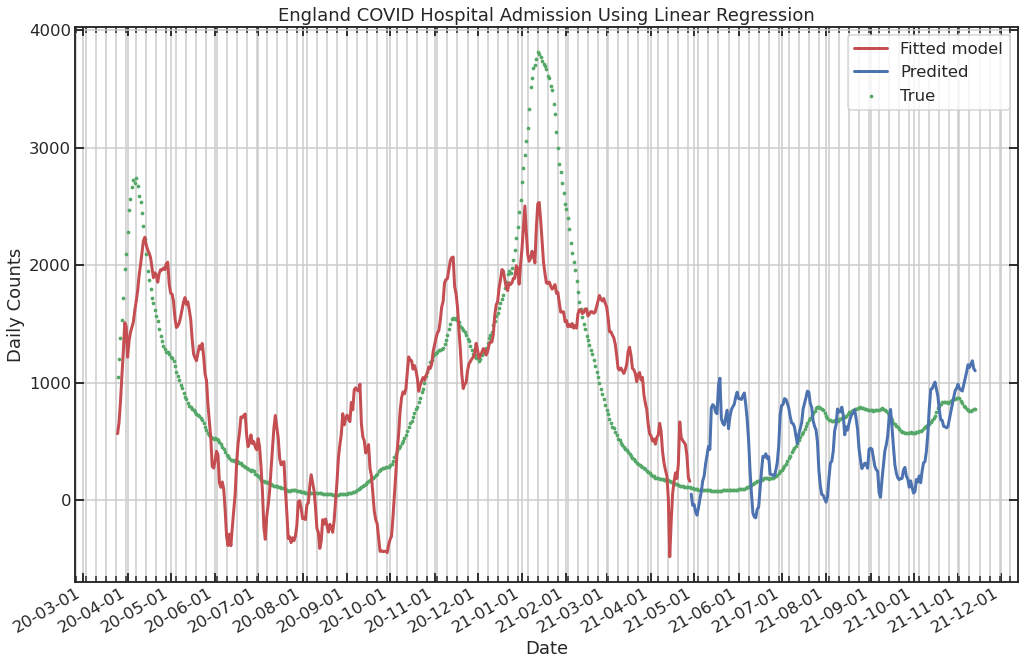

In [850]:
fig, ax = plt.subplots(figsize=(15,10),sharex= True, facecolor='white')

# Plot the true data
ax.scatter(df_new.index, df_new['hospital_admission'], s=5, c='g', label='True')

# Define function of the fitted model
fitted_model = np.dot(X_new, np.transpose(lin_reg.coef_)) + lin_reg.intercept_

prediction = np.dot(X_test_new, np.transpose(lin_reg.coef_)) + lin_reg.intercept_ 

# Polt the fitted model
ax.plot(df_new.index[:400], fitted_model, 'r', label='Fitted model')
ax.plot(df_new.index[-199:],prediction, 'b', label='Predited')

ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)

ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Counts')

# Format the ticks
ax.xaxis.set_major_locator(months)
dateFmt = mdates.DateFormatter('%y-%m-%d')
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
ax.set_title('England COVID Hospital Admission Using Linear Regression')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()

By observing the plots I got, I found out that for the fitted model, trends are very similar from 20-04-01 to 20-06-01 and from 20-11-01 to 21-05-01, despite the fact that there are some unusual fluctuations. In these two periods, they also have three similar positions of their peaks, although peak values have large differences. However, in other periods, the fitted model has a bad performance, such as from 20-06-01 to 20-11-01. The fitted curve is highly volatile, while the true cure is almost smoothing. I suppose this fitting part and difference between peak values at 21-02-01 have mainly reduced the fit accuracy.

As for the predited model based on test data, it behaves even worse. It seems to me that they have very few similarities, especially from 21-05-01 to 21-07-01. This is why the mean squared error has such a big value. 

I think the main reason why this model is not very good may be that the chosen model should not be linear. I would try polynomial regression later. Another possible reason is that I may lack some important covariates. I will consider adding the number of vaccinated people as one of covariates.

## Part 5. Predict the covid severity in the future 10 days

Even though the fitted model's behaviour is not very good, I still want to use this model to make further predictions in the future 10 days to roughly see what range would the hospital admissions be in. I get the true values of all covariates from the original dataframe (2021-11-03 to 2021-11-13) to predict hospital admission in the next 10 days due to time lagged.

In [851]:
df.dropna(axis=0, how='any', inplace=True) # in case there are none values
x1_pred = df['work'][-10:]
x2_pred = df['Public_Transport'][-10:]
x3_pred = df['Parks'][-10:]
x4_pred = df['retail_and_recreation'][-10:]
x5_pred = df['grocery_and_pharmacy'][-10:]
x6_pred = df['residential'][-10:]

# Define function of the predicted model using parameters getting from the fitted model
prediction_future10days = lin_reg.coef_[0]*x1_pred + lin_reg.coef_[1]*x2_pred + lin_reg.coef_[2]*x3_pred + lin_reg.coef_[3]*x4_pred + lin_reg.coef_[4]*x5_pred + lin_reg.coef_[5]*x6_pred + lin_reg.intercept_

Then, I visualize the predicted results.

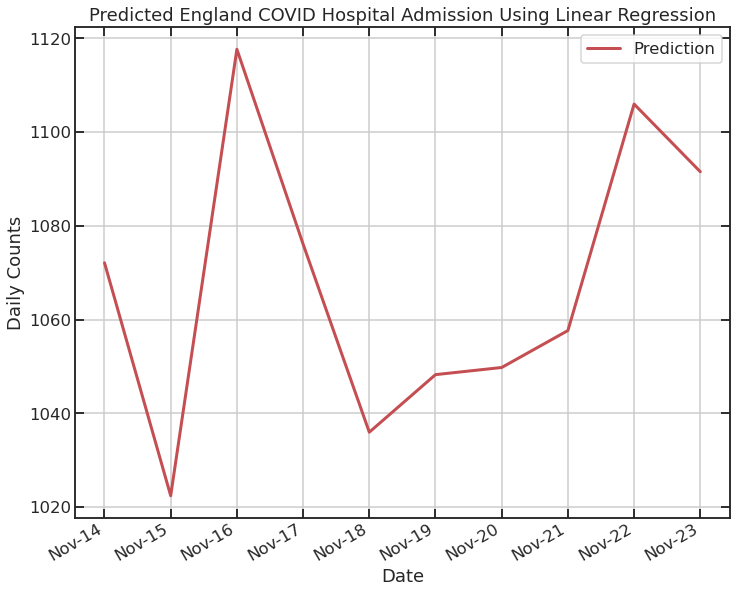

In [852]:
fig, ax = plt.subplots(figsize=(11,9),sharex= True, facecolor='white')

time = pd.date_range('2021-11-14', periods=10, freq='1D')
ax.plot(time, prediction_future10days, label='Prediction', color='r')

ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)

ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Counts')

# Format the ticks
days = mdates.DayLocator()
ax.xaxis.set_major_locator(days)
dateFmt = mdates.DateFormatter('%b-%d')
ax.xaxis.set_major_formatter(dateFmt)

ax.set_title('Predicted England COVID Hospital Admission Using Linear Regression')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()

From this plot, I could see the range of hospital admissions is approximately from 790 to 910, only as a rough reference. The trend has no point of reference, because it is largely likely to be some meaningless fluctuation, just like what I got from prediction based on test data.

## Part 6. Experiment using polynomial regression to create a model

### (a) Create a model

I try to use polynomial regression to build a different model to see if I could get better fitting results. Firstly, I use PolynomialFeatures to generate polynomial and interaction features when the maximal degree of the polynomial features is 2. This means I tranform X_new (400 x 6) to X_new_ploy (400 x 27), and fit a new linear regression under this format. Finally, I get 1 intercept and 27 coefficients for each interaction feature.

In [853]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_features= PolynomialFeatures(degree=2, include_bias=False)
X_new_poly = polynomial_features.fit_transform(X_new)
model = LinearRegression()
model.fit(X_new_poly, y_train)

# Get the intercept and coefficients of the model
print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)

Intercept: 
 -1864.034778894515
Coefficients: 
 [ 2.05448635e+01 -2.93496880e+02 -5.17338169e+00 -3.55184130e+02
  2.88798023e+02 -1.52588688e+03  1.76946118e+01 -2.11430216e+01
 -2.22393983e-01  5.58227317e+00 -2.09235965e+01  2.79772767e+01
 -3.71223057e+00 -3.01682676e-01 -2.07516175e+01  2.62303889e+01
 -1.09166564e+02  3.88335191e-02 -1.32710476e+00 -1.59958656e+00
 -8.10870789e+00  4.00478120e+00 -8.16287543e+00 -7.33573965e+00
  5.17555384e+00 -1.49650825e+00 -9.22789930e+01]


### (b) Back test the data

Then I evaluate the new fitted model and get a satisfactory result. The fit accuracy is much closer to 1 than that for linear regression, which means the new model is alomost perfect for every data.

In [854]:
# Evaluate the fitted model

print('Fit Accuracy: \n', model.score(X_new_poly, y_train))

Fit Accuracy: 
 0.9113676491703148


However, when calculating the mean squared error, the value is much larger than that for linear regression. This indicates the predicted part based on test data is not good, may have many erratic fluctuations. The only reason why this resluts happened is overfitting.

In [855]:
# Calculate rmse
from sklearn.metrics import mean_squared_error 

X_test = [x_work_test, x_pt_test, x_parks_test, x_rr_test, x_gp_test, x_r_test]
X_test_new = np.transpose(X_test)
X_test_new_poly = polynomial_features.fit_transform(X_test_new)
pred = model.predict(X_test_new_poly)
error = np.sqrt(mean_squared_error(y_test,pred)) 
print("Error: \n",error)

Error: 
 869.0487393114372


### (c) Visualize the fitted model

To verify my suspicions, I make some plots.

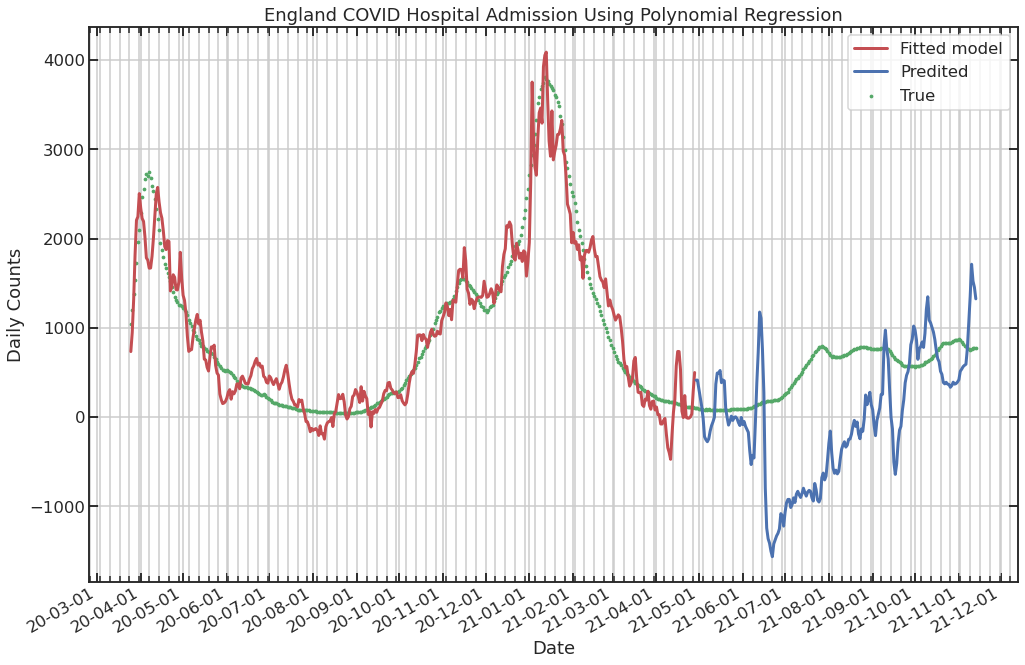

In [856]:
fig, ax = plt.subplots(figsize=(15,10),sharex= True, facecolor='white')

# Plot the true data
ax.scatter(df_new.index, df_new['hospital_admission'], s=5, c='g', label='True')

# Define function of the model
fitted_model = np.dot(X_new_poly, np.transpose(model.coef_)) + model.intercept_

prediction = np.dot(X_test_new_poly, np.transpose(model.coef_)) + model.intercept_

# Polt the fitted model
ax.plot(df_new.index[:400], fitted_model, 'r', label='Fitted model')
ax.plot(df_new.index[-199:],prediction, 'b', label='Predited')

ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)

ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Counts')

# Format the ticks
ax.xaxis.set_major_locator(months)
dateFmt = mdates.DateFormatter('%y-%m-%d')
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
ax.set_title('England COVID Hospital Admission Using Polynomial Regression')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()

Clearly, the fitted model behaves quite well. Trends, peak values and peak positions are all similar to true values, except for some minor fluctions. However, as for the predicted part, nothing is similar to true values, which means this model fitted by polynomial regression has no ability to predict future changes, but have a perfect behaviour on train data sets. This is a typical feature for over-fitting. Since polynomial regression is overfitting, there is no need to use this model to predict in the future ten days because it is pointless.

## Part 7. Consider the number of people get vaccinated as a new covariate

###  (a) Consturct a new dataframe

After a failed polynomial regression, maybe adding a new covariate would work for linear regression, so I choose to consider the number of people get vaccinated. Therefore, I construct a new DataFrame containing this covariate and shift 10 days for it because usually antibodies develop about 10 days after vaccination.

In [857]:
Vaccinated_clean_noise = df_Eng['Vaccinated'].rolling(window=7).mean()
df_new_2 = df.shift(10)
df_new_2['hospital_admission'] = hospital_admission_clean_noise
df_new_2['Vaccinated']= Vaccinated_clean_noise
df_new_2['Vaccinated']=df_new_2['Vaccinated'].shift(10) # shift 10 days 
df_new_2.dropna(axis=0, how='any', inplace=True)
display(df_new_2)

,work,Public_Transport,Parks,retail_and_recreation,grocery_and_pharmacy,residential,hospital_admission,Vaccinated
date,,,,,,,,
2021-01-27,-45.857143,-64.428571,-17.000000,-64.428571,-25.857143,18.571429,2863.714286,230525.428571
2021-01-28,-46.000000,-64.428571,-16.142857,-64.571429,-25.857143,18.428571,2789.714286,234876.714286
2021-01-29,-46.142857,-64.571429,-18.428571,-64.857143,-26.285714,18.428571,2698.714286,251122.000000
2021-01-30,-46.285714,-64.714286,-19.142857,-65.000000,-26.428571,18.428571,2614.857143,261507.285714
2021-01-31,-46.000000,-64.428571,-16.000000,-64.428571,-25.571429,18.142857,2523.285714,272971.571429
...,...,...,...,...,...,...,...,...
2021-11-09,-30.428571,-26.857143,39.571429,-5.142857,4.428571,6.428571,756.428571,280489.142857
2021-11-10,-30.428571,-27.142857,34.571429,-5.714286,4.857143,6.428571,758.428571,279610.000000
2021-11-11,-29.142857,-27.142857,28.285714,-7.000000,4.571429,6.428571,769.857143,280811.428571


### (b) Create a model

Then I split the data mamually, do linear regression and get the intercept and coefficients of the new model.

In [858]:
# Split the train data and test data first

from sklearn.linear_model import LinearRegression

x_work_train = df_new_2['work'][:200]
x_work_test = df_new_2['work'][-86:]
x_pt_train = df_new_2['Public_Transport'][:200]
x_pt_test = df_new_2['Public_Transport'][-86:]
x_parks_train = df_new_2['Parks'][:200]
x_parks_test = df_new_2['Parks'][-86:]
x_rr_train =  df_new_2['retail_and_recreation'][:200]
x_rr_test = df_new_2['retail_and_recreation'][-86:]
x_gp_train = df_new_2['grocery_and_pharmacy'][:200]
x_gp_test = df_new_2['grocery_and_pharmacy'][-86:]
x_r_train = df_new_2['residential'][:200]
x_r_test = df_new_2['residential'][-86:]
x_v_train= df_new_2['Vaccinated'][:200]
x_v_test = df_new_2['Vaccinated'][-86:]
y_train = df_new_2['hospital_admission'][:200]
y_test  = df_new_2['hospital_admission'][-86:]

In [859]:
# Construct a list containing all the values of covariates in order
X = [x_work_train, x_pt_train, x_parks_train, x_rr_train,  x_gp_train, x_r_train, x_v_train]
X_new = np.transpose(X)

# Define the linear regression model and fit
lin_reg = LinearRegression()
lin_reg.fit(X_new, y_train)

# Get the intercept and coefficients of the model
print('Intercept: \n', lin_reg.intercept_)
print('Coefficients: \n', lin_reg.coef_)

Intercept: 
 2382.491809197877
Coefficients: 
 [ 2.71672961e+01 -1.27011543e+01  8.24859836e+00  1.89024984e+01
 -1.50204422e+02 -1.04092521e+02 -1.49187950e-03]


### (c) Back test the data

The fit accuracy also becomes quite higher compared with the model without having the number of people get vaccinated as a covariate, which means data of vaccinated truly has strong correlations with hospital admissions and is a key covariate. With it, the fit accuracy increases by almost 0.25. The fitted model must become much more better.

In [860]:
# Evaluate the fitted model
print('Fit Accuracy: \n', lin_reg.score(X_new, y_train))

Fit Accuracy: 
 0.873164369644433


Similarly, the mean squared error becomes smaller, indicating this predicted model has more powerful predictive capabilities.I can tell this model is the best one so far.

In [861]:
# Calculate rmse
from sklearn.metrics import mean_squared_error 

X_test = [x_work_test, x_pt_test, x_parks_test, x_rr_test, x_gp_test, x_r_test, x_v_test]
X_test_new = np.transpose(X_test)
pred = lin_reg.predict(X_test_new)
error = np.sqrt(mean_squared_error(y_test,pred)) 
print("Error: \n",error)

Error: 
 220.17639955162264


### (d) Visualize the fitted model

Let's see how well this model is done.

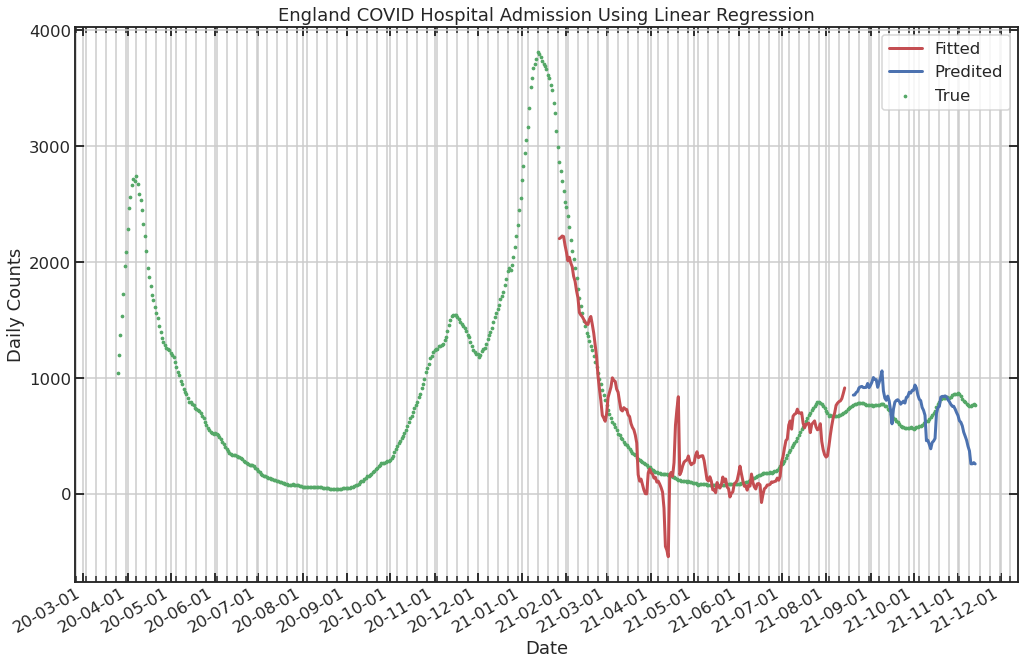

In [862]:
fig, ax = plt.subplots(figsize=(15,10),sharex= True, facecolor='white')

# Plot the true data
ax.scatter(df_new.index, df_new['hospital_admission'], s=5, c='g', label='True')

# Define function of the fitted model
model_2 = np.dot(X_new, np.transpose(lin_reg.coef_)) + lin_reg.intercept_

prediction_2 = np.dot(X_test_new, np.transpose(lin_reg.coef_)) + lin_reg.intercept_

# Polt the fitted model
ax.plot(df_new_2.index[:200], model_2, 'r', label='Fitted')
ax.plot(df_new_2.index[-86:],prediction_2, 'b', label='Predited')

ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)

ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Counts')

# Format the ticks
ax.xaxis.set_major_locator(months)
dateFmt = mdates.DateFormatter('%y-%m-%d')
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
ax.set_title('England COVID Hospital Admission Using Linear Regression')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()

From this plot, I could see that the general trend of the fitted curve is quite similar to the true curve, except for the sharp fluctuations between 21-04-01 and 21-05-01. Besides, the peak position, which should be at 21-08-01, is much closer to 21-07-01 in the fitted curve, but the peak value is almost the same. For the predicted part, although the mean suqared error decreases, this part is still not quite good, both for trend and peak value. However, the peak shape at 21-10-15 in the predicted model is a little bit similar to the peak shape around 21-11-01 in the true model. The value range of this predited model also do not have a superb deviation from the true value range compared with the model without people get vaccinated as a covariate. Therefore, this model is so much better, but has a slight sign of over-fitting.

I think the reason why this model becomes better is that it has much less data after adding vaccinated as a covariate, so it is less likely to be overfitting, but it can still happen, just as shown in this picture. Besides, I suppose that vaccinated is a key covariate for doing linear regression. Without it, the model could not be linear.

### (e) Predict for the next 10 days

Using this model to predict for the next ten days is slightly more valuable to see what would happen in the future. 

In [863]:
# Get the true values of all covariates from the original dataframe (2021-11-03 to 2021-11-13) 
# to predict hospital admission in the next 10 days because of time lagged

df.dropna(axis=0, how='any', inplace=True) # in case there are none values
x1_pred = df['work'][-10:]
x2_pred = df['Public_Transport'][-10:]
x3_pred = df['Parks'][-10:]
x4_pred = df['retail_and_recreation'][-10:]
x5_pred = df['grocery_and_pharmacy'][-10:]
x6_pred = df['residential'][-10:]
x7_pred = Vaccinated_clean_noise[-10:].values

# Define function of the predicted model using parameters getting from the fitted model
prediction_future10days_2 = lin_reg.coef_[0]*x1_pred + lin_reg.coef_[1]*x2_pred + lin_reg.coef_[2]*x3_pred + lin_reg.coef_[3]*x4_pred + lin_reg.coef_[4]*x5_pred + lin_reg.coef_[5]*x6_pred + lin_reg.coef_[6]*x7_pred + lin_reg.intercept_

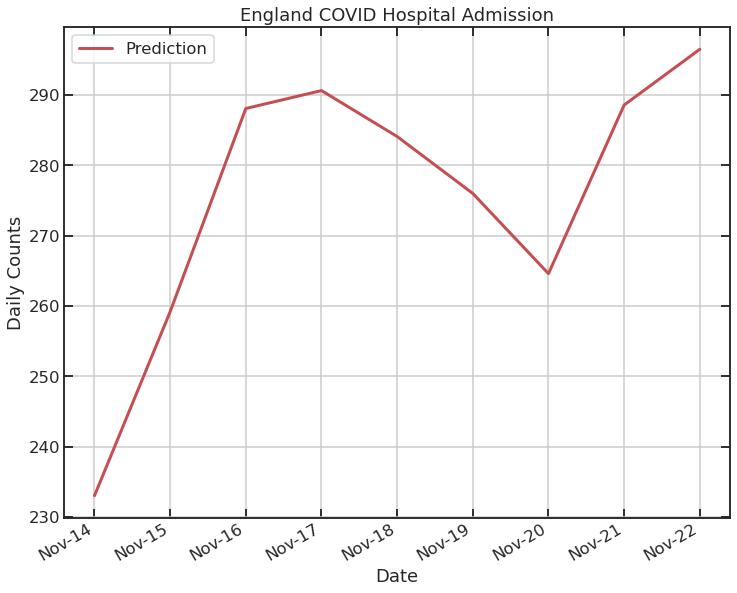

In [864]:
# Visualize the predicted results
fig, ax = plt.subplots(figsize=(11,9),sharex= True, facecolor='white')

time = pd.date_range('2021-11-14', periods=10, freq='1D')
ax.plot(time, prediction_future10days_2, label='Prediction', color='r')

ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)

ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Counts')

# Format the ticks
days = mdates.DayLocator()
ax.xaxis.set_major_locator(days)
dateFmt = mdates.DateFormatter('%b-%d')
ax.xaxis.set_major_formatter(dateFmt)

ax.set_title('England COVID Hospital Admission')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()

From this plot, I could see that the prediction of values of hospital admissions is much smaller than that prediction before, and is around 230 to 300. The trend is to increase, then decrease and increase again. Basically, this is a small fluctuation. Considering the effectiveness of vaccine, it is very reasonable to see the reduction of Covid severity in the future compared with prediction without vaccinated as a covariate.

### (f) Experiment using polynomial regression

Just the same steps as previouly done.

In [865]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_features= PolynomialFeatures(degree=2, include_bias=False)
X_new_poly = polynomial_features.fit_transform(X_new)
model = LinearRegression()
model.fit(X_new_poly, y_train)

# Get the intercept and coefficients of the model
print('Intercept: \n', model.intercept_)
print('Coefficients: \n', model.coef_)

Intercept: 
 5617.628680514267
Coefficients: 
 [ 3.37799860e+02 -2.35780438e+02  9.89443349e+01 -1.17259928e+02
 -6.41492331e+02 -1.21979893e+03 -1.55681290e-02  8.85573785e+00
  1.02014868e+01  2.24617700e+00  3.57471658e+00 -1.02471196e+01
  6.89827730e+01 -9.93805586e-05 -1.14968795e+01  3.44029593e+00
 -4.68170674e+00 -1.16857027e+01 -6.55186447e+01 -1.60149002e-04
  1.68440155e-01 -2.55682100e-01 -1.98234320e+00  9.79858508e+00
 -2.40428209e-05  2.69724623e+00  9.75029268e-01  1.88612336e+01
  8.22258550e-05  1.24458624e+01 -1.59703360e+01  2.91162335e-04
  3.22422496e+01  3.34029924e-04  7.06868892e-09]


The fit accuracy is quite good for the training part, almost close to 1.

In [866]:
# Evaluate the fitted model

print('Fit Accuracy: \n', model.score(X_new_poly, y_train))

Fit Accuracy: 
 0.9926130061569792


The behaviour in the testing part is poor, which means over-fitting happens again.

In [867]:
# Calculate rmse
from sklearn.metrics import mean_squared_error 

X_test = [x_work_test, x_pt_test, x_parks_test, x_rr_test, x_gp_test, x_r_test, x_v_test]
X_test_new = np.transpose(X_test)
X_test_new_poly = polynomial_features.fit_transform(X_test_new)
pred = model.predict(X_test_new_poly)
error = np.sqrt(mean_squared_error(y_test,pred)) 
print("Error: \n",error)

Error: 
 622.4784901327129


To show what happend, I make some plots.

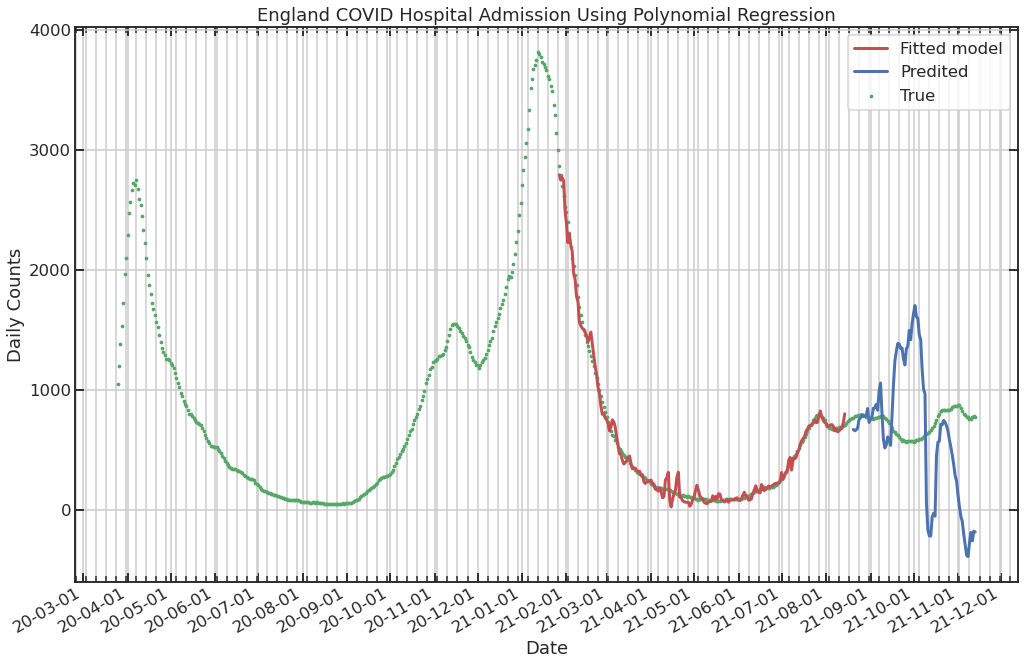

In [868]:
fig, ax = plt.subplots(figsize=(15,10),sharex= True, facecolor='white')

# Plot the true data
ax.scatter(df_new.index, df_new['hospital_admission'], s=5, c='g', label='True')

# Define function of the model
fitted_model = np.dot(X_new_poly, np.transpose(model.coef_)) + model.intercept_

prediction = np.dot(X_test_new_poly, np.transpose(model.coef_)) + model.intercept_

# Polt the fitted model
ax.plot(df_new_2.index[:200], fitted_model, 'r', label='Fitted model')
ax.plot(df_new_2.index[-86:],prediction, 'b', label='Predited')

ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)

ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Counts')

# Format the ticks
ax.xaxis.set_major_locator(months)
dateFmt = mdates.DateFormatter('%y-%m-%d')
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
ax.set_title('England COVID Hospital Admission Using Polynomial Regression')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()

This attempt illustrates when doing polynomial regression, over-fiting always happens, no matter whether having vaccinated as a covariate or not. Therefore, the model should be linear, and consider covariates including vaccinated could make it have better performance.

## Part 8. Summary

In conclusion, I try to build four models, having vaccinated covariate or not, and linear or polynomial. 

I found out that the model would have better performance when considering vaccinated covariate, which means we can not neglect the impact of the number of people vaccinated on model, no matter for linear or polynomial.

Compared with linear model, polynomial model always behaves better on training data, but worse on testing data. This is because an overfitting has occurred. 

Therefore, the best model to predict covid severity should be a linear regression model having the vaccinated covariate so far. To further improve this model, maybe I should consider more covariates to get better performance on test data, such as the age profile.